# Определение возраста покупателей

## Исследовательский анализ данных

Описание проекта.


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv', sep=',')

except:
    labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv', sep=',')

In [3]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [4]:
data_info(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,005041.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выведем долю пропущенных значений для каждого столбца датафреймов.

In [5]:
pd.DataFrame(labels.isna().mean()*100)

,0
file_name,0.0
real_age,0.0


Пропущенных значений нет.

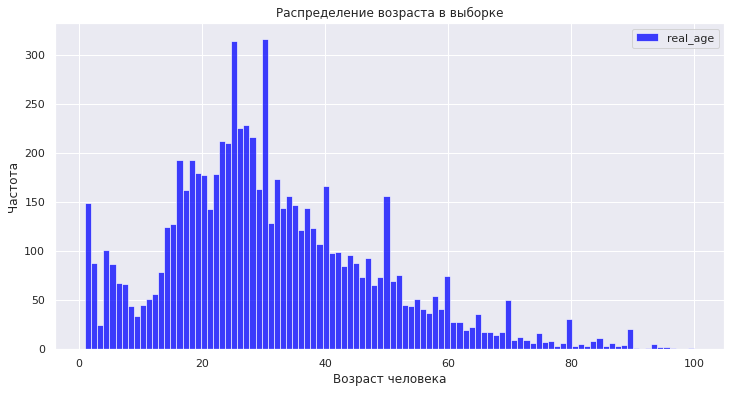

In [6]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=labels, x="real_age", color="blue", label="real_age", bins=100)

plt.ylabel('Частота')
plt.xlabel('Возраст человека')
plt.title('Распределение возраста в выборке')
plt.legend() 
plt.show()

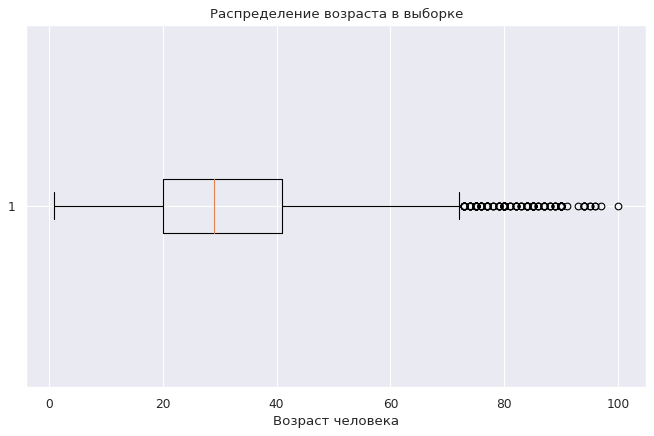

In [7]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(labels['real_age'], vert=False)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст человека')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


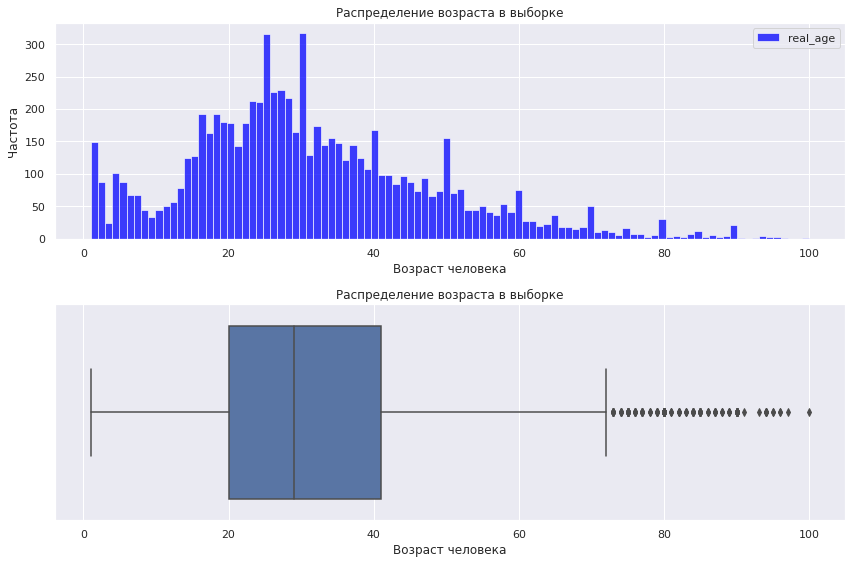

In [9]:
# Создаем фигуру и два подграфика (axes)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Первый график - гистограмма
sns.set_theme(style="darkgrid")
sns.histplot(data=labels, x="real_age", color="blue", label="real_age", ax=ax1, bins=100)
ax1.set_ylabel('Частота')
ax1.set_xlabel('Возраст человека')
ax1.set_title('Распределение возраста в выборке')
ax1.legend()

# Получим диапазон по оси X для согласования
x_min, x_max = ax1.get_xlim()

# Второй график - boxplot
sns.boxplot(x=labels['real_age'], orient = "v", ax=ax2)
ax2.set_xlim(x_min, x_max)  # согласуем диапазоны по X
ax2.set_xlabel('Возраст человека')
ax2.set_title('Распределение возраста в выборке')
plt.tight_layout()
plt.show()

Из гистограммы распределения по возрастам видно, что распределение несимметричное с максимумом, соответствующим 29 годам (медиана). Также наблюдается небольшой пик для очень маленьких возрастов. Возраст 50% людей лежит в диапазоне от 20 до 40 лет. Однако имеются и фотографии людей старше 75 лет. Таким образом, есть возраста, которые плохо представлены в датасете.

In [8]:
data_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
path = '/datasets/faces/'

In [10]:
 data_datagen_flow = data_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode='raw',
        target_size=(224, 224),
        seed=42)

Found 7591 validated image filenames.


In [11]:
images, labels = next(data_datagen_flow)

Получились признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

Возраст 1


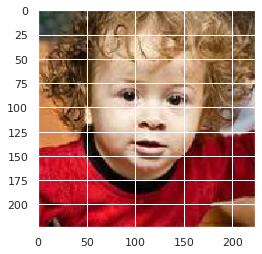

In [12]:
print('Возраст', labels[0])
plt.imshow(images[0])

Выведем первые 10 фотографий вместе с возрастом.

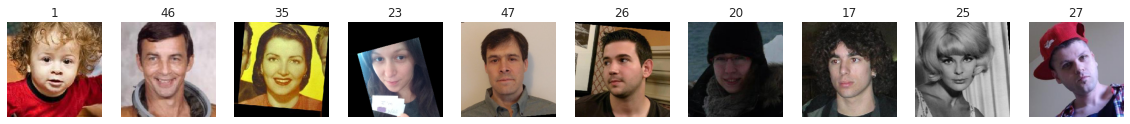

In [13]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

Вроде бы возраст действительно примерно соответсвует фотографии.

Таким образом, для решения поставленной задачи имеется 7591 изображение и файл с реальными возрастами, соответствующими этим изображениям. Распределение по возрастам - несимметричное, с максимумом, соответствующим примерно 29 годам. Также наблюдается небольшой пик для очень маленьких возрастов. Возраст 50% людей лежит в диапазоне от 20 до 40 лет. Однако имеются и фотографии людей старше 75 лет. Есть возраста, которые плохо представлены в датасете, например люди старше 60 лет. Скорее всего модель будет хуже предсказывать возраст людей старше 60 лет. Также есть сомнения насчет маленьких детей. На первом фото изображен ребенок, которому один год, но ему (ей?) вполне можно дать и полгода и три.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

#!/usr/bin/env python
# coding: utf-8

# In[ ]:





# In[ ]:



import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error



def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv', sep=',')
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        #vertical_flip=True,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    
    return train_datagen_flow


# In[ ]:

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv', sep=',')
    test_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255)
    
    val_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'/final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    
    return val_datagen_flow


# In[ ]:

path = '/datasets/faces/'
x_train = load_train(path)
x_test = load_test(path)

# In[ ]:

def create_model(input_shape):
       
          
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])

    return model

# In[ ]:

def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow,
            validation_data=val_datagen_flow,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2, shuffle=True)
    
    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/10
2025-07-19 07:15:47.049450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-19 07:15:47.525066: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 144s - loss: 168.7595 - mae: 9.7905 - val_loss: 697.8394 - val_mae: 21.3556
Epoch 2/10
190/190 - 100s - loss: 91.8117 - mae: 7.3030 - val_loss: 526.6261 - val_mae: 17.7357
Epoch 3/10
190/190 - 99s - loss: 71.5796 - mae: 6.4719 - val_loss: 302.7340 - val_mae: 12.8814
Epoch 4/10
190/190 - 95s - loss: 54.2588 - mae: 5.6534 - val_loss: 177.9873 - val_mae: 9.8836
Epoch 5/10
190/190 - 97s - loss: 44.4215 - mae: 5.1516 - val_loss: 79.5191 - val_mae: 6.9260
Epoch 6/10
190/190 - 98s - loss: 35.1836 - mae: 4.5825 - val_loss: 84.8635 - val_mae: 6.9303
Epoch 7/10
190/190 - 99s - loss: 31.6744 - mae: 4.3848 - val_loss: 74.3453 - val_mae: 6.3932
Epoch 8/10
190/190 - 100s - loss: 27.1389 - mae: 4.0199 - val_loss: 74.9454 - val_mae: 6.3915
Epoch 9/10
190/190 - 100s - loss: 24.1372 - mae: 3.8086 - val_loss: 76.3506 - val_mae: 6.6916
Epoch 10/10
190/190 - 97s - loss: 22.1503 - mae: 3.6800 - val_loss: 97.3873 - val_mae: 7.3928
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 97.3873 - mae: 7.3928
Test MAE: 7.3928


```

## Анализ обученной модели

По условию задачи требуется определить возраст человека по фотографии. Это задача регрессии. Для ее решения использовалась готовая нейронная сеть ResNet50, предобученная на датасете ImageNet. ResNet50 без заморозки (backbone.trainable = True) показала лучшие результаты. Поскольку мы решаем задачу регресси, то на выходе сети у нас имеется  один нейрон с функцией активации ReLU.

В качестве фунции потерь использовалась Mean Squared Error, а для оценки качества использовалась метрика Mean Absolute Error. По условию задачи она должна быть ниже 8. В результате обучения ResNet50 уже на 10 эпохе получилось значение метрики 7.4. Таким образом, условие задачи выполнено.

Попытка написать свою собственную архитектуру из сверточных слоев привела к значительно худшим результатам. Модель плохо сходилась и значения метрики MAE не превышали 12 на 50 эпохах.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы